In [2]:
import torch
from torchvision import datasets, transforms

#Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

#Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# test set
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle=True)

In [3]:
# Creating a neural architecture

In [4]:
import torch

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
        
        

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# Class probabilities
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


Let's get the most likely class using the ps.topk method

In [7]:
top_k, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 5 examples
print(top_class[:10,:])

tensor([[0],
        [0],
        [4],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [8]:
equals = top_class == labels.view(*top_class.shape)

In [9]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')


Accuracy: 4.6875%


In [10]:
#  Now let's train our network and include our validation pass so we can measure 
# how well the network is performing on the test set

In [16]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
step = 0

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        tot_test_loss = 0
        #Number of correct prediction on the test set
        test_correct = 0
        # Let's Turning off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim =1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()
                
    # Get mean loss to enable comparison between train and test sets
    train_loss = tot_train_loss/len(trainloader.dataset)
    test_loss = tot_test_loss/len(testloader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    
    print("Epochs: {}/{}..".format(e+1, epochs),
         "Training Loss: {:.3f}..".format(train_loss),
         "Test Loss: {:.3f}..".format(test_loss),
         "Test Accuracy: {:.3f}".format(test_correct/len(testloader.dataset)))

Epochs: 1/30.. Training Loss: 0.008.. Test Loss: 0.007.. Test Accuracy: 0.834
Epochs: 2/30.. Training Loss: 0.006.. Test Loss: 0.007.. Test Accuracy: 0.842
Epochs: 3/30.. Training Loss: 0.006.. Test Loss: 0.006.. Test Accuracy: 0.869
Epochs: 4/30.. Training Loss: 0.005.. Test Loss: 0.006.. Test Accuracy: 0.865
Epochs: 5/30.. Training Loss: 0.005.. Test Loss: 0.006.. Test Accuracy: 0.872
Epochs: 6/30.. Training Loss: 0.005.. Test Loss: 0.006.. Test Accuracy: 0.868
Epochs: 7/30.. Training Loss: 0.005.. Test Loss: 0.006.. Test Accuracy: 0.869
Epochs: 8/30.. Training Loss: 0.004.. Test Loss: 0.006.. Test Accuracy: 0.869
Epochs: 9/30.. Training Loss: 0.004.. Test Loss: 0.006.. Test Accuracy: 0.869
Epochs: 10/30.. Training Loss: 0.004.. Test Loss: 0.006.. Test Accuracy: 0.871
Epochs: 11/30.. Training Loss: 0.004.. Test Loss: 0.005.. Test Accuracy: 0.880
Epochs: 12/30.. Training Loss: 0.004.. Test Loss: 0.006.. Test Accuracy: 0.873
Epochs: 13/30.. Training Loss: 0.004.. Test Loss: 0.006.. Tes

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

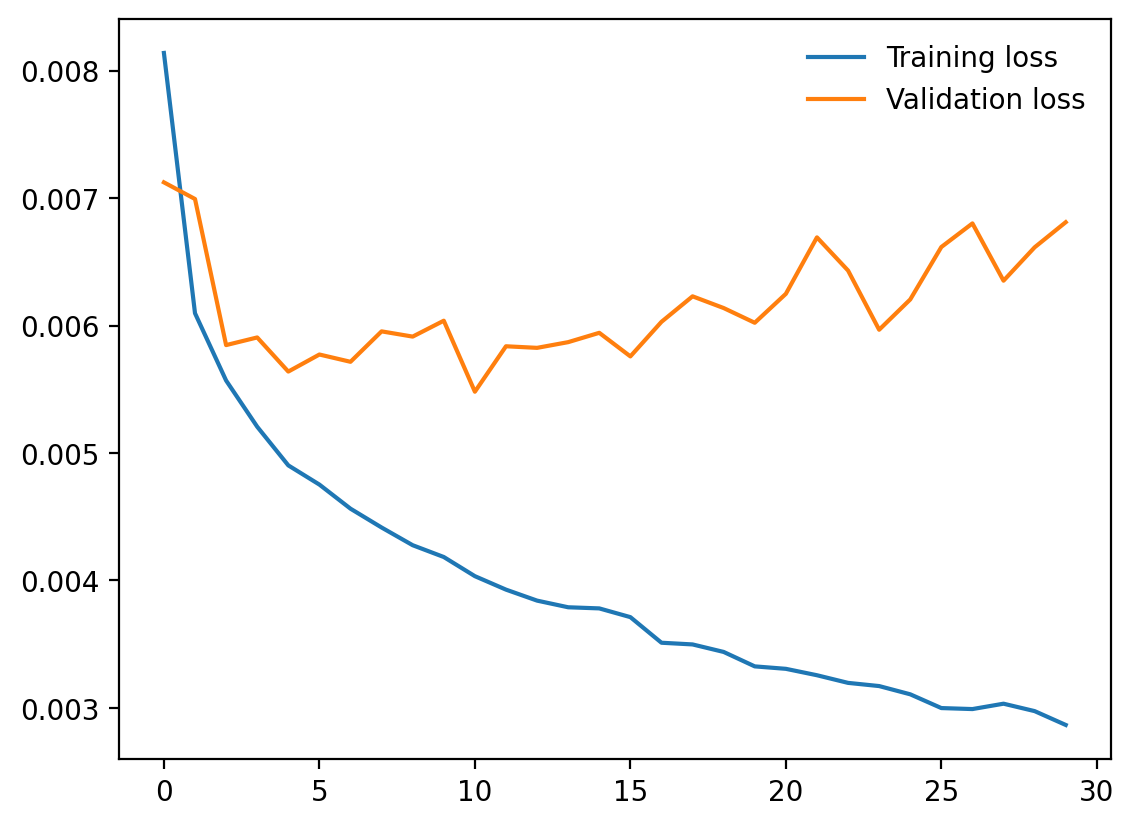

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Looking at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.



In [19]:
#  To fix this problem, we can use a strategy called early-stopping

In [20]:
# Alternatively, we can use dropout strategy
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        
        #Setup the droput module with 20% drop probabilities
        self.dropout = nn.Dropout(p=0.20)
        
    def forward(self, x):
        #Flatten the tensor
        x = x.view(x.shape[0], -1)
        #Using dropout
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        #output
        x = F.log_softmax(self.fc4(x), dim=1)
        
        
        return x
        
        
        


In [21]:
# Train the model

In [24]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer =optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
step = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps= torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        
        print("Epochs:{}/{}..".format(e+1, epochs),
              "Training Loss: {:.3f}..".format(train_losses[-1]),
              "Test Loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}..".format(accuracy/len(testloader))
             )

Epochs:1/30.. Training Loss: 0.607.. Test Loss: 0.490.. Test Accuracy: 0.825..
Epochs:2/30.. Training Loss: 0.490.. Test Loss: 0.440.. Test Accuracy: 0.839..
Epochs:3/30.. Training Loss: 0.453.. Test Loss: 0.435.. Test Accuracy: 0.839..
Epochs:4/30.. Training Loss: 0.433.. Test Loss: 0.443.. Test Accuracy: 0.843..
Epochs:5/30.. Training Loss: 0.424.. Test Loss: 0.403.. Test Accuracy: 0.856..
Epochs:6/30.. Training Loss: 0.411.. Test Loss: 0.402.. Test Accuracy: 0.858..
Epochs:7/30.. Training Loss: 0.403.. Test Loss: 0.387.. Test Accuracy: 0.861..
Epochs:8/30.. Training Loss: 0.397.. Test Loss: 0.398.. Test Accuracy: 0.858..
Epochs:9/30.. Training Loss: 0.392.. Test Loss: 0.396.. Test Accuracy: 0.859..
Epochs:10/30.. Training Loss: 0.389.. Test Loss: 0.391.. Test Accuracy: 0.862..
Epochs:11/30.. Training Loss: 0.384.. Test Loss: 0.393.. Test Accuracy: 0.865..
Epochs:12/30.. Training Loss: 0.380.. Test Loss: 0.375.. Test Accuracy: 0.867..
Epochs:13/30.. Training Loss: 0.376.. Test Loss: 

In [25]:
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

import matplotlib.pyplot as plt

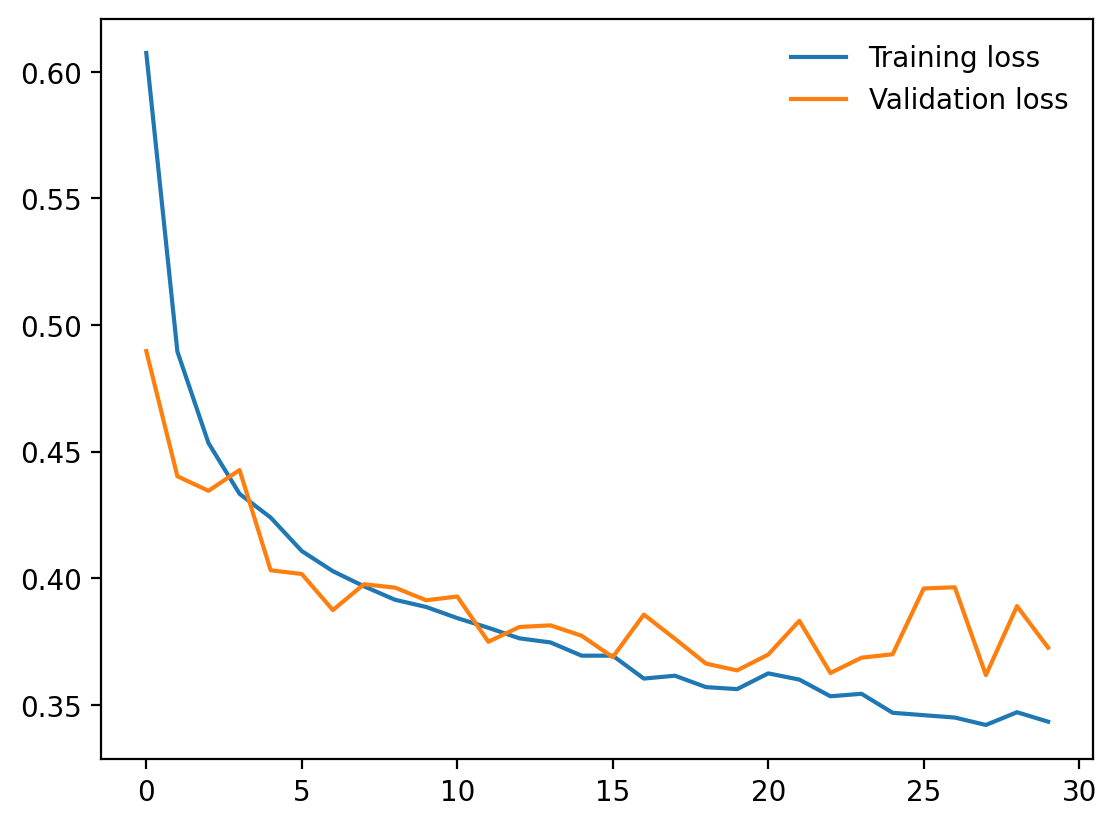

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label ='Validation loss')
plt.legend(frameon=False)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable

In [28]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

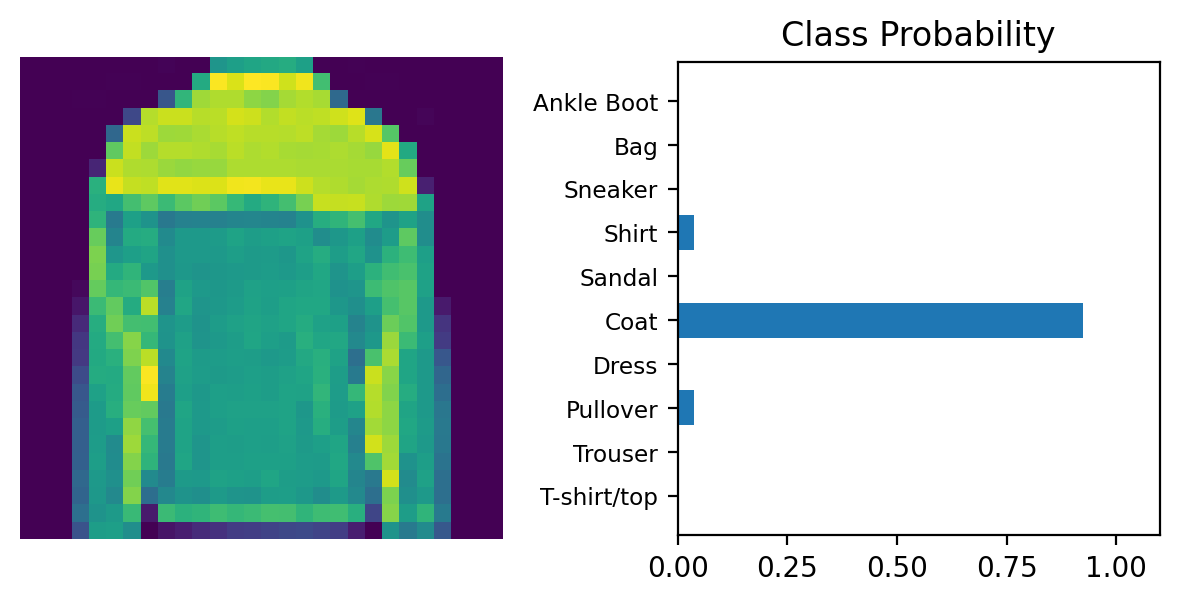

In [30]:
# Testing the network

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
#Convert 2D images to 1D vector

img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img

with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')